In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import graph_tool.all as gt
# import networkx as nx
import random
import math
from numpy.random import seed, random, randint

from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
from thoi.heuristics import simulated_annealing, greedy
from thoi.commons import gaussian_copula_covmat

# Multivariate Time Series Study

Here, we study the relationship between the O-information and the structural balance-energy U using the datasets ([Zenodo link here](https://zenodo.org/records/7118947)) accompaying the paper Cliff et al (2023) "Unifying pairwise interactions in complex dynamics" Nat Comput Sci 3, 883–893

Make sure the packages above are installed and that the you have downloaded the MTS timeseries data (link above).

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

In [3]:
def network_energy(corrmat: np.ndarray, cuberootQ: bool = False) -> float:
    """
    Compute the network energy-balance U from a correlation matrix.

    ---
    Notes:
    code adapted from: https://github.com/majidsaberi/NetEnergyCogControl/blob/main/NetworkEnergy.R
    Originally written in R by Majid Saberi, March, 2024
    
    in this version, you can choose whther using the cuberoot, such as in Saberi et al (2024) or without, such as in Marvel and Strogatz (2009)
    Adapted to Python by Enrico Caprioglio, July, 2025
    """

    if corrmat.ndim != 2 or corrmat.shape[0] != corrmat.shape[1]:
        raise ValueError("corrmat must be a square 2-D array")

    n = corrmat.shape[0]
    if n < 3:
        raise ValueError("At least three nodes are required (matrix must be 3×3 or larger)")

    total_energy = 0.0
    triplet_count = 0

    # iterate over unordered triplets (i < j < k)
    for i in range(n - 2):
        for j in range(i + 1, n - 1):
            for k in range(j + 1, n):
                prod = corrmat[i, j] * corrmat[i, k] * corrmat[k, j]
                
                if cuberootQ == False:
                    # Marvel and Strogatz (2009) – no cube root
                    triplet_energy = np.sign(prod) * abs(prod)
                else:
                    # cube-root variant (such as Saberi et al (2024))
                    triplet_energy = np.sign(prod) * np.cbrt(abs(prod))

                total_energy += triplet_energy
                triplet_count += 1

    return -total_energy / triplet_count

In [4]:
def cov2corr(covmat):
    std = np.sqrt(np.diag(covmat))
    denom = np.outer(std, std)
    corrmat = covmat / denom

    return corrmat

In [5]:
def collect_O_vs_U(dataset, order, cuberootQ=False):

    nObs, nVars = np.shape(dataset)
    num_comb=math.comb(nVars, order)
    nplets, nplets_O_info = greedy(dataset, order, order, repeat=num_comb)
    
    # get correlation matrix
    covmat=gaussian_copula_covmat(dataset)
    corrmat=cov2corr(covmat)

    U_data = []
    O_data = []

    for (idx, nplet) in enumerate(nplets):
        U = network_energy(corrmat[np.ix_(nplet, nplet)], cuberootQ=cuberootQ)
        O = nplets_O_info[idx]

        U_data.append(U)
        O_data.append(O)

    return U_data, O_data

In [6]:
# load dataset
datasets = np.load('/Users/ec627/Documents/Sussex/papers/PRL Synergistic Motifs/data/database.pkl', allow_pickle=True)

In [7]:
# get dataset with real data
real_datasets = []
for dataset in datasets.keys():
    if 'real' in datasets[dataset]['labels']:
        real_datasets.append(dataset)

In [ ]:
# you can use this cell to explore the dataset
# (for more info, see the Supplementary Information accompanying Cliff et al "Unifying pairwise interactions in complex dynamics":
# https://www.readcube.com/articles/supplement?doi=10.1038%2Fs43588-023-00519-x&index=0)

# for instance, the financial data can be found by searching:
#  - 'ForEx', 'SNP500', 'DJIA'

# to search from the entire dataset uncomment the following
# matching_keys = [(idx, k) for (idx, k) in enumerate(datasets.keys()) if "ForEx" in k] # PEMS

# to search from the real datasets list:
matching_keys = [(idx, k) for (idx, k) in enumerate(real_datasets) if "ForEx" in k]

matching_keys

[(460, 'ForEx_N-886_P-9_2010-01-01-lr'),
 (461, 'ForEx_N-885_P-9_2010-01-01'),
 (462, 'ForEx_N-986_P-9_2013-05-26-lr'),
 (463, 'ForEx_N-575_P-9_2017-03-06-lr'),
 (464, 'ForEx_N-574_P-9_2017-03-06'),
 (465, 'ForEx_N-445_P-9_2019-05-18-lr'),
 (466, 'ForEx_N-444_P-9_2019-05-18'),
 (467, 'ForEx_N-135_P-9_2021-01-30-lr'),
 (468, 'ForEx_N-134_P-9_2021-01-30')]

key = ForEx_N-886_P-9_2010-01-01-lr, shape = (886, 9)


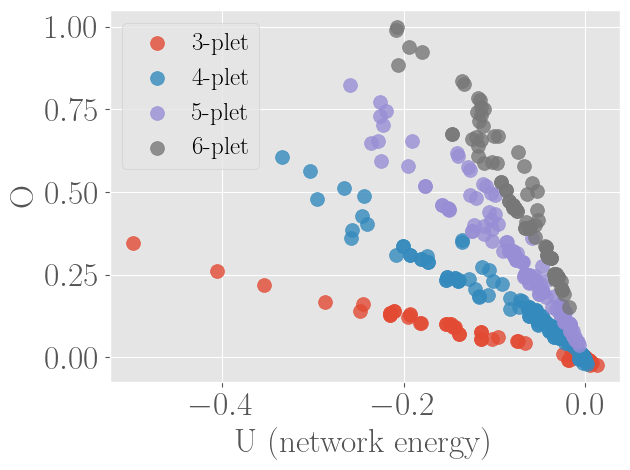

In [9]:
# select here the desired index (use the search above):
sel_idx=460

key=real_datasets[sel_idx]
# key='TestWEATHnoise_S1'
dataset_test=np.transpose(datasets[key]['data'])
print(f'key = {key}, shape = {dataset_test.shape}')

orders=[3,4,5,6]
for order in orders:
    U_data, O_data = collect_O_vs_U(dataset_test, order, cuberootQ=False)

    plt.scatter(U_data, O_data, marker="o", s=100, label=f"{order}-plet",alpha=0.8)

plt.xlabel("U (network energy)", fontsize =24)
plt.ylabel("O", fontsize =24)
plt.tick_params(axis='both', labelsize=24)
# plt.title(key)
plt.tight_layout()
# plt.xscale('symlog', linthresh=1e-2, linscale=1)
# plt.yscale('symlog', linthresh=1e-2, linscale=1)
plt.legend(
    # title="n-plet order",
    fontsize=18,
    # title_fontsize=22,
    loc="upper left",
    frameon=True,
    handletextpad=0.4
)
plt.show()

# plt.savefig(
#     "/Users/ec627/Documents/Sussex/papers/PRL Synergistic Motifs/final_figures/FinancialDataExample.png",
#     dpi=800,
#     bbox_inches="tight"
#     )

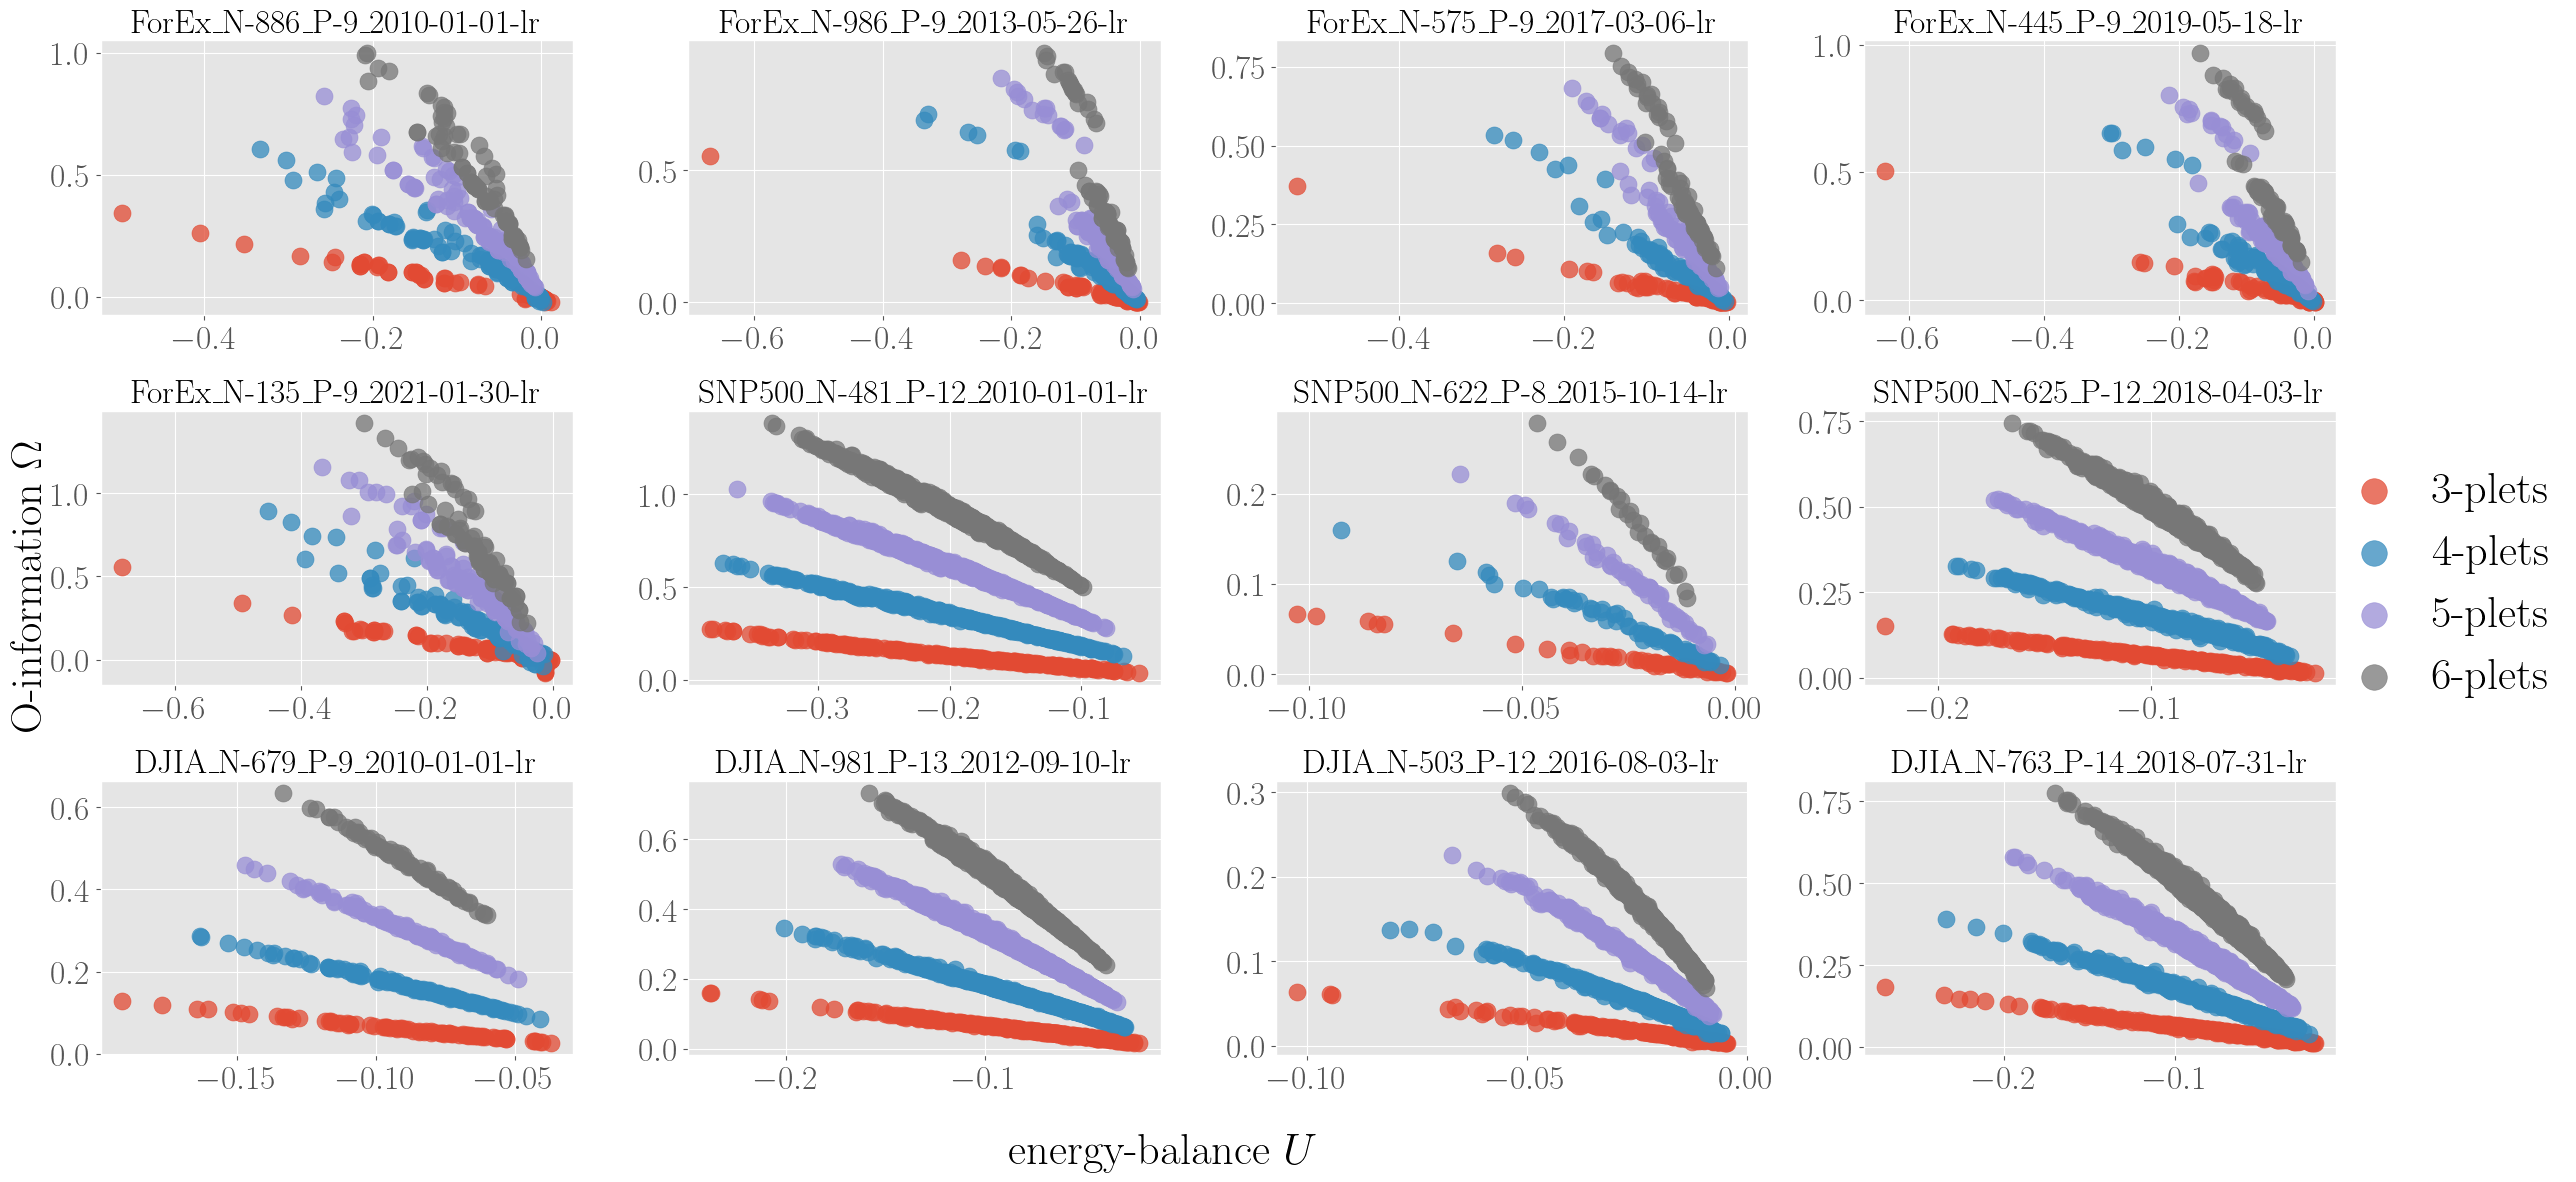

In [10]:
# here we plot all the foreign exchange logarithmic returns from the dataset

matching_keys = [(idx, k) for (idx, k) in enumerate(real_datasets) if "-lr" in k] 

# create grid for plot
n_files = len(matching_keys)
cols  = 4
rows  = math.ceil(n_files / cols)

fig, axes = plt.subplots(
    rows, cols,
    figsize=(cols * 6, rows * 4),
    squeeze=False,
    sharex=False, sharey=False,
)

for ax, (idx, filename) in zip(axes.flat, matching_keys):
    
    key=real_datasets[idx]
    dataset_test=np.transpose(datasets[key]['data'])

    orders=[3,4,5,6]
    for order in orders:
        U_data, O_data = collect_O_vs_U(dataset_test, order, cuberootQ=False)

        ax.scatter(U_data, O_data, marker="o", label=f"{order}-plets",alpha=0.75,s=150)

    ax.set_title(key, fontsize=24)
    ax.tick_params(axis='both', labelsize=24)
    # ax.set_xscale('symlog', linthresh=1e-2, linscale=1)
    # ax.set_yscale('symlog', linthresh=1e-2, linscale=1)

fig.supxlabel(r"energy-balance $U$", fontsize=32)
fig.supylabel(r"O-information $\Omega$", fontsize=32)

handles, labels = ax.get_legend_handles_labels()   # any one axis will do
fig.legend(
    handles, labels,
    loc="center left",
    bbox_to_anchor=(.97, 0.5),
    frameon=False,
    fontsize=32,
    handletextpad=0.3,
    markerscale=1.5
)

fig.tight_layout(pad=1.8)
plt.show()

fig.savefig(
    "/Users/ec627/Documents/Sussex/papers/PRL Synergistic Motifs/final_figures/Supplemental_Material/FinancialData.png",
    dpi=800,
    bbox_inches="tight"
    )

Below we plot examples from medicine, physiology, finance, and others.

Medical data:
- `UEA Heartbeat`
- `UEA HandMovementDirection`
- `UEA ArticularyWordRecognition`

Physiological data:
- `UEA Cricket`
- `UCLA res-state fMRI schizophrenia`
- `mouse fMRI`

Others:
- `UEA PEMS-SF`
- `epidemic incidence`
- `Dow–Jones Industrial Average index`

Just change the indeces variable defined below to visualize different datasets.

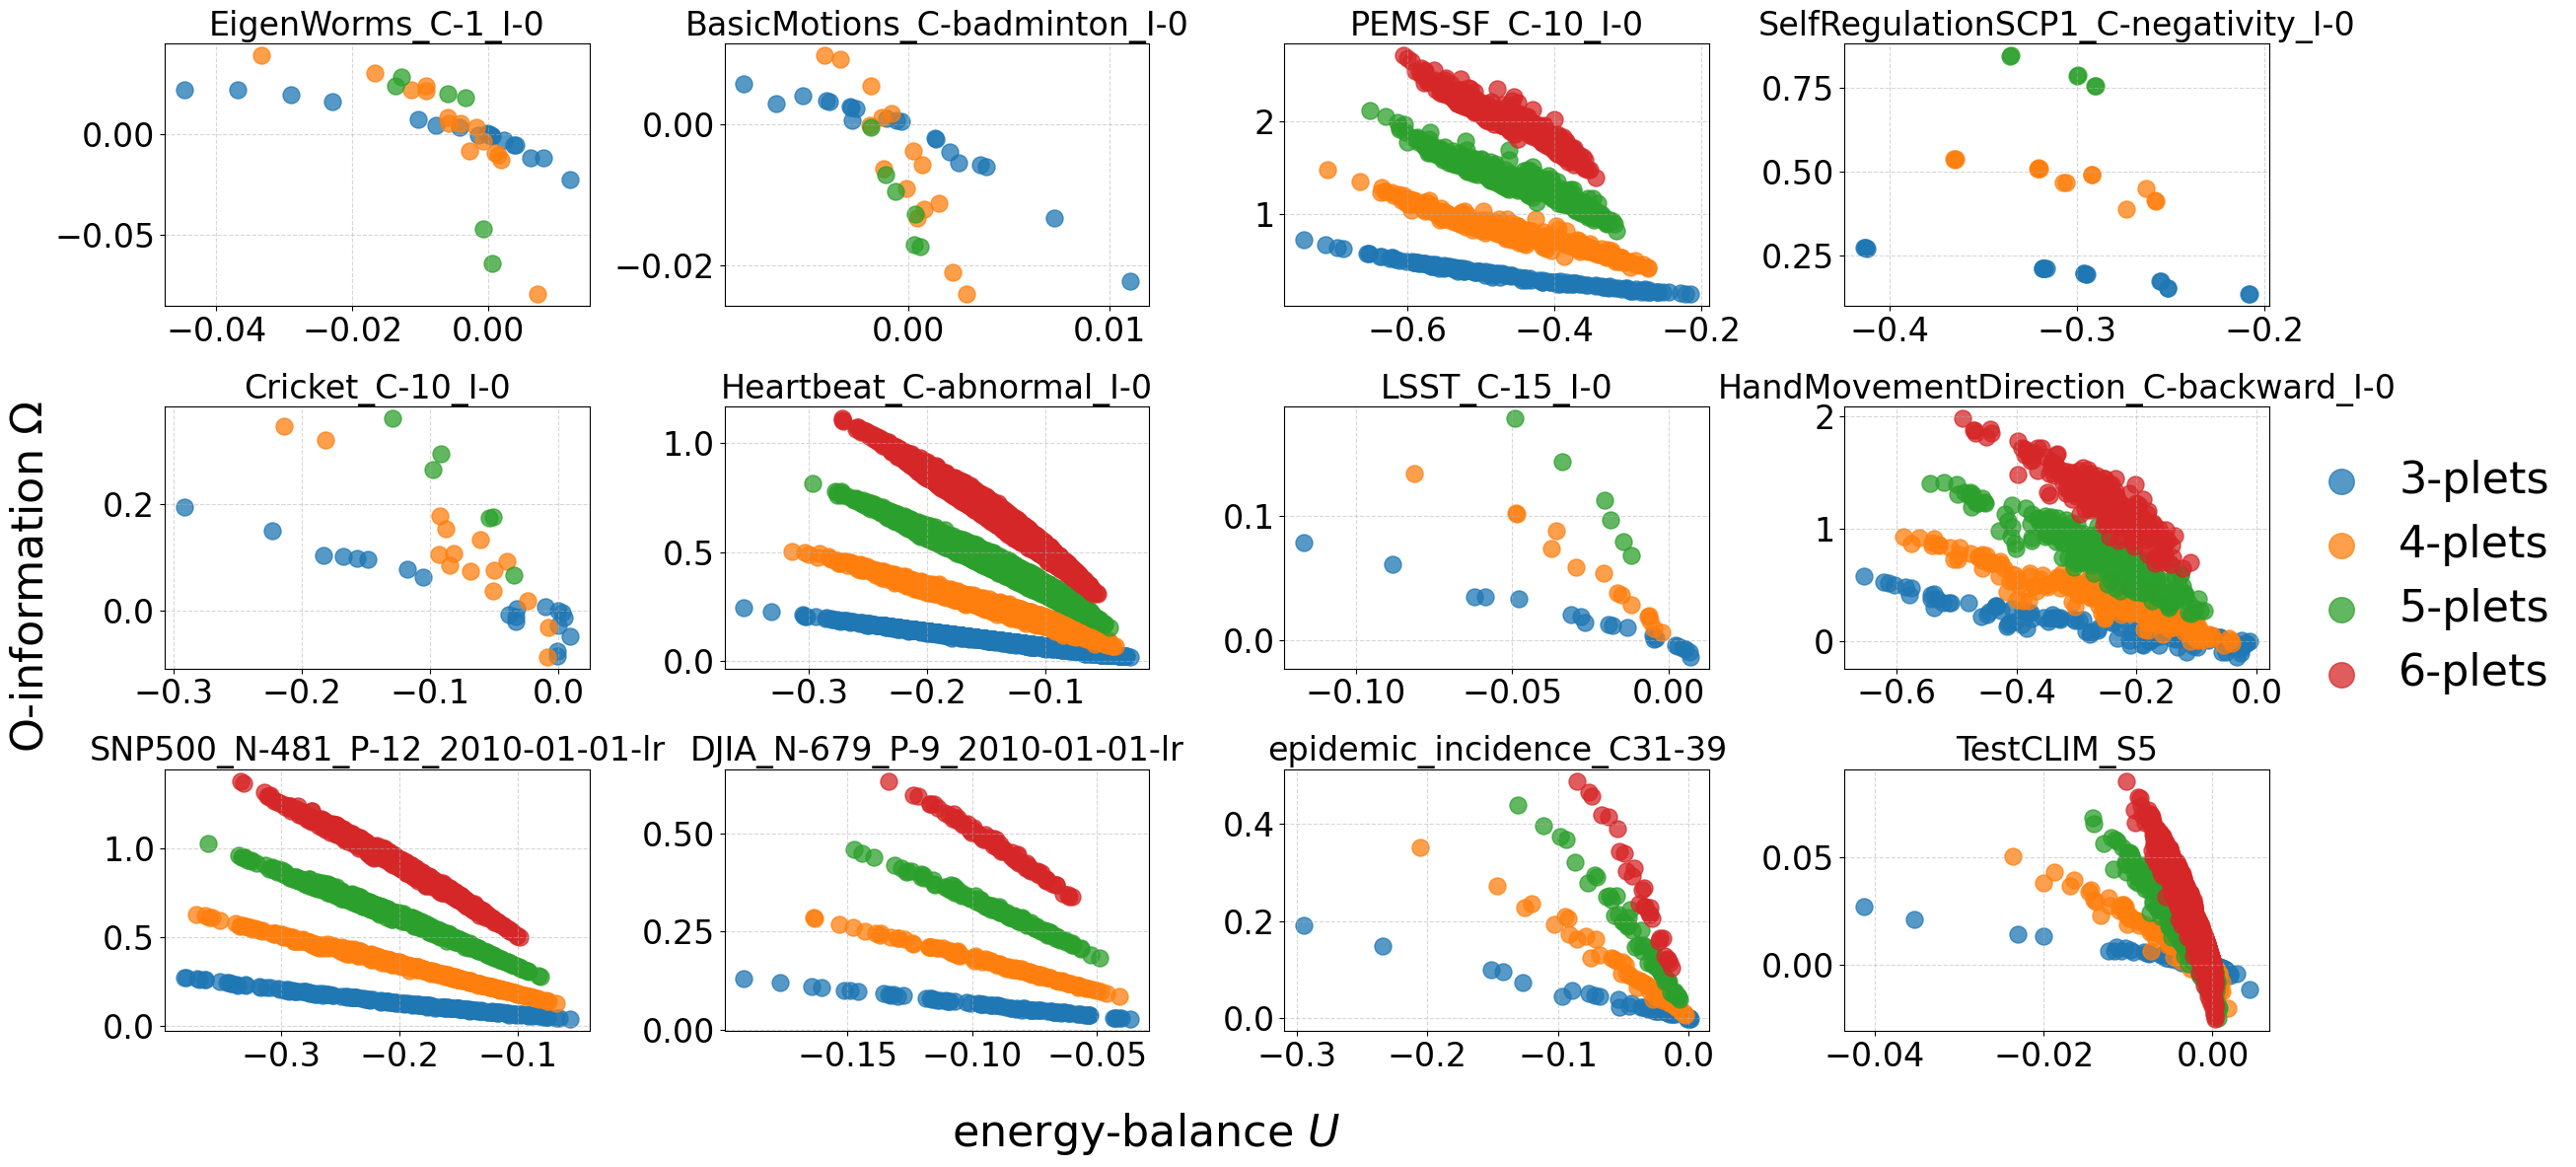

In [ ]:
indeces = [149, 252, 350, 15, 168, 469, 475, 0, 92, 270, 538,]

plt.style.use('default')

matching_keys = [(idx, k) for (idx, k) in enumerate(real_datasets) if idx in indeces]
extra_clim = [    
    (992, 'TestCLIM_S5')
]
matching_keys.extend(extra_clim)

# create grid for plot
n_files = len(matching_keys)
cols  = 4
rows  = math.ceil(n_files / cols)

fig, axes = plt.subplots(
    rows, cols,
    figsize=(cols * 6, rows * 4),
    squeeze=False,
    sharex=False, sharey=False,
)

fig.patch.set_facecolor('white')        # figure background
for ax in axes.flat:
    ax.set_facecolor('white')           # axes background
    for spine in ax.spines.values():    # axis lines (spines)
        spine.set_color('black')
    ax.tick_params(color='black', labelcolor='black')
    ax.grid(True, which='both', linestyle='--', alpha=0.5)


for ax, (idx, filename) in zip(axes.flat, matching_keys):

    dataset_test=np.transpose(datasets[filename]['data'])

    if datasets[filename]['data'].shape[0] == 6:
        orders=[3,4,5]
    else:
        orders=[3,4,5,6]
    for order in orders:
        U_data, O_data = collect_O_vs_U(dataset_test, order, cuberootQ=False)

        ax.scatter(U_data, O_data, marker="o", label=f"{order}-plets",alpha=0.75,s=150)

    ax.set_title(filename, fontsize=24)
    ax.tick_params(axis='both', labelsize=24)
    # ax.set_xscale('symlog', linthresh=1e-2, linscale=1)
    # ax.set_yscale('symlog', linthresh=1e-2, linscale=1)

fig.supxlabel(r"energy-balance $U$", fontsize=32)
fig.supylabel(r"O-information $\Omega$", fontsize=32)

handles, labels = ax.get_legend_handles_labels()   # any one axis will do
fig.legend(
    handles, labels,
    loc="center left",
    bbox_to_anchor=(.97, 0.5),
    frameon=False,
    fontsize=32,
    handletextpad=0.3,
    markerscale=1.5
)

fig.tight_layout(pad=1.8)
plt.show()

Below, we collect the data for Table S2 in the SM

In [13]:
dataset=np.transpose(datasets['ForEx_N-886_P-9_2010-01-01-lr']['data'])
covmat=gaussian_copula_covmat(dataset)
corrmat=cov2corr(covmat)

orders=[3,4,5,6,7]

eig_stats = {}

for order in orders:

    num_comb=math.comb(9, order)
    nplets, nplets_O_info = greedy(dataset, order, order, repeat=num_comb)
    
    # get correlation matrix
    covmat=gaussian_copula_covmat(dataset)
    corrmat=cov2corr(covmat)

    U_data = []
    O_data = []
    all_eigs = []

    for (idx, nplet) in enumerate(nplets):

        subsys = corrmat[np.ix_(nplet, nplet)]

        U = network_energy(subsys, cuberootQ=False)
        O = nplets_O_info[idx]

        U_data.append(U)
        O_data.append(O)

        max_eigval = np.linalg.eigvalsh(subsys).max() - 1
        # subtract 1 since we are interested in spectral radius of W, i.e., the off-diag elements of the correlation matrix
        all_eigs.append(max_eigval)

    all_eigs = np.array(all_eigs)
    eig_min  = all_eigs.min()
    eig_max  = all_eigs.max()
    eig_mean = all_eigs.mean()
    n_crit = np.sum(all_eigs >= 1.0)   # use > 1.0 if you want strictly critical
    frac_crit = 100.0 * n_crit / len(all_eigs)

    eig_stats[order] = (eig_min, eig_mean, eig_max)

    print(f"order = {order}")
    print(f"number of {order}-plets:  {len(all_eigs)}")
    print(f"percentage critical: {frac_crit:.3f}")
    print(f"min eigenvalue:  {eig_min:.3f}")
    print(f"mean eigenvalue: {eig_mean:.3f}")
    print(f"max eigenvalue:  {eig_max:.3f}")
    print()



order = 3
number of 3-plets:  84
percentage critical: 36.905
min eigenvalue:  0.125
mean eigenvalue: 0.796
max eigenvalue:  1.616



order = 4
number of 4-plets:  126
percentage critical: 76.984
min eigenvalue:  0.415
mean eigenvalue: 1.236
max eigenvalue:  2.108



order = 5
number of 5-plets:  126
percentage critical: 97.619
min eigenvalue:  0.883
mean eigenvalue: 1.683
max eigenvalue:  2.571



order = 6
number of 6-plets:  84
percentage critical: 100.000
min eigenvalue:  1.363
mean eigenvalue: 2.132
max eigenvalue:  2.994



order = 7
number of 7-plets:  36
percentage critical: 100.000
min eigenvalue:  2.045
mean eigenvalue: 2.582
max eigenvalue:  3.439



In [14]:
# save data to plot in Julia:

sel_idx=460
folderpath='/Users/ec627/Documents/Data/financial_data_ananalysis/'

key=real_datasets[sel_idx]
dataset_test=np.transpose(datasets[key]['data'])
print(f'key = {key}, shape = {dataset_test.shape}')

orders=[3,4,5,6,7]
for order in orders:
    U_data, O_data = collect_O_vs_U(dataset_test, order, cuberootQ=False)

    filename=key+f'_order_{order}.npz'
    res={'U_data': U_data, 'O_data': O_data, 'order': order}
    
    # np.savez(folderpath+filename, **res)


key = ForEx_N-886_P-9_2010-01-01-lr, shape = (886, 9)
